# Model fitting 2: SSC + galaxy template

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs


In [2]:
print(jetset.__version__)

1.2.0rc6


In [3]:
test_SEDs

['/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [4]:
data=Data.from_file(test_SEDs[3])



***  binning data  ***
---> N bins= 90
---> bin_widht= 0.2



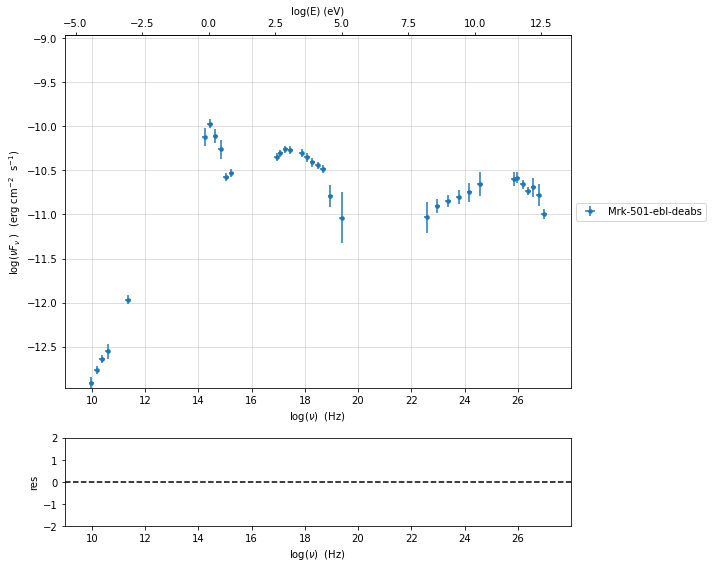

In [5]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()

In [6]:
sed_data.save('Mrk_501.pkl')

## Phenomenological model constraining

### Spectral indices


*** evaluating spectral indices for data ***



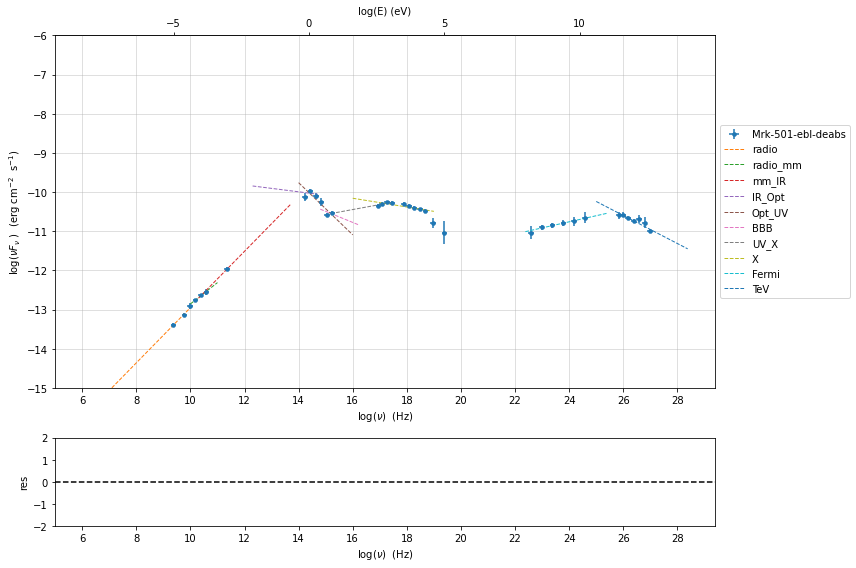

In [7]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()
p.rescale(y_min=-15,y_max=-6)

### Sed shaper

In [8]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=True,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10. , 21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP

---> class:  HSP




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-6.411144e-02,-6.411144e-02,7.838965e-03,--,-4.778764e-02,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.751721e-03,-1.751721e-03,1.127030e-03,--,3.576201e-03,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.703747e+01,1.703747e+01,9.437354e-02,--,1.626870e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.030068e+01,-1.030068e+01,1.884114e-02,--,-1.025412e+01,-3.000000e+01,0.000000e+00,False
host_galaxy,nuFnu_p_host,-1.006557e+01,-1.006557e+01,5.462528e-02,--,-1.025412e+01,-1.225412e+01,-8.254123e+00,False
host_galaxy,nu_scale,1.730764e-02,1.730764e-02,3.694887e-03,--,0.000000e+00,-5.000000e-01,5.000000e-01,False


---> sync       nu_p=+1.703747e+01 (err=+9.437354e-02)  nuFnu_p=-1.030068e+01 (err=+1.884114e-02) curv.=-6.411144e-02 (err=+7.838965e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.310993e-01,-1.310993e-01,3.244183e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-3.300446e-02,-3.300446e-02,2.072517e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.549603e+01,2.549603e+01,2.235468e-01,--,2.556357e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.057945e+01,-1.057945e+01,4.332976e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.549603e+01 (err=+2.235468e-01)  nuFnu_p=-1.057945e+01 (err=+4.332976e-02) curv.=-1.310993e-01 (err=+3.244183e-02)



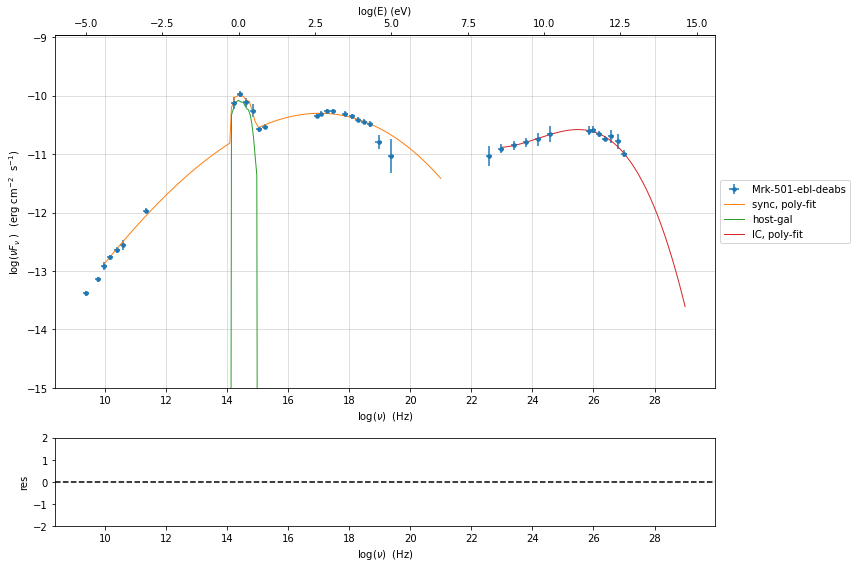

In [9]:
my_shape.IC_fit(fit_range=[23., 29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.rescale(y_min=-15)

### Model constraining

In this step we are not fitting the model, we are just obtaining the phenomenological `pre_fit` model, that will be fitted in using minuit ore least-square bound, as shown below

In [10]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E11,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet_gal_templ.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,1.046425e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.360000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082278e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False


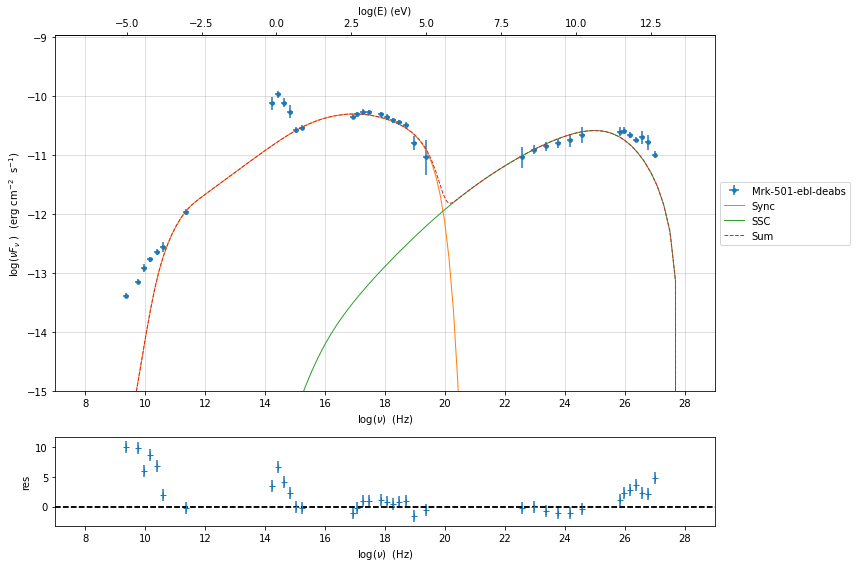

In [11]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.rescale(y_min=-15,x_min=7,x_max=29)

## Model fitting

### Model fitting with LSB

In [12]:
from jetset.model_manager import  FitModel
from jetset.jet_model import Jet

jet_lsb=Jet.load_model('prefit_jet_gal_templ.pkl')
jet_lsb.set_gamma_grid_size(200)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082278e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205572e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046425e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


In [13]:
fit_model_lsb=FitModel( jet=jet_lsb, name='SSC-best-fit-lsb',template=my_shape.host_gal) 
fit_model_lsb.show_model()


--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-lsb  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

--------------------------------------------------------------------------------
individual component description

--------------------------------------------------------------------------------
jet model description
--------------------------------------------------------------------------------
name: jet_leptonic  

electrons distribution:
 type: lppl  
 gamma energy grid size:  201
 gmin grid : 1.487509e+02
 gmax grid : 2.310708e+06
 normalization  True
 log-values  False

radiative fields:
 seed photons grid size:  100
 IC emission grid size:  100
 source emissivity lower bound :  1.000000e-120
 spectral components:
   name:Sum, state: o

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082278e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205572e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046425e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
model description
--------------------------------------------------------------------------------
name: host_galaxy  
type: template  

--------------------------------------------------------------------------------


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
host_galaxy,nuFnu_p_host,nuFnu-scale,erg / (cm2 s),-1.006557e+01,-2.000000e+01,2.000000e+01,False,False
host_galaxy,nu_scale,nu-scale,Hz,1.730764e-02,-2.000000e+00,2.000000e+00,False,False


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [14]:
fit_model_lsb.composite_expr='jet_leptonic + host_galaxy '

In [15]:
fit_model_lsb.freeze('jet_leptonic','z_cosm')
fit_model_lsb.freeze('jet_leptonic','R_H')
fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]
fit_model_lsb.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_lsb.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_lsb.host_galaxy.parameters.nu_scale.frozen=True

In [16]:
from jetset.minimizer import fit_SED,ModelMinimizer

model_minimizer_lsb=ModelMinimizer('lsb')
best_fit_lsb=model_minimizer_lsb.fit(fit_model_lsb,sed_data,10.0**11,10**29.0,fitname='SSC-best-fit-lsb',repeat=3)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=8.40986e+00

fit run: 1
- old chisq=8.40986e+00


0it [00:00, ?it/s]

- best chisq=8.33083e+00

fit run: 2
- old chisq=8.33083e+00


0it [00:00, ?it/s]

- best chisq=8.30769e+00

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-lsb


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,9.629577e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.094901e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.649381e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,5.732044e+03,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.179803e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,2.270824e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.364911e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.227782e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.391102e+01,1.000000e-04,--,False,False



converged=True
calls=41
mesg=


'The relative error between two consecutive iterates is at most 0.000000'

dof=21
chisq=8.307691, chisq/red=0.395604 null hypothesis sig=0.993696

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,9.629577e+01,9.629577e+01,1.604038e+02,--,1.487509e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.094901e+06,2.094901e+06,9.384097e+05,--,2.310708e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,2.649381e+01,2.649381e+01,9.557869e+01,--,3.082278e+01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,5.732044e+03,5.732044e+03,9.690316e+03,--,1.045843e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.179803e+00,2.179803e+00,2.636698e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.270824e-01,2.270824e-01,4.581071e-02,--,3.205572e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.364911e+16,1.364911e+16,1.776107e+16,--,1.046425e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.227782e-02,1.227782e-02,4.927832e-03,--,5.050000e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,4.391102e+01,4.391102e+01,2.478637e+01,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




In [17]:
best_fit_lsb.save_report('SSC-best-fit-lsb.pkl')
model_minimizer_lsb.save_model('model_minimizer_lsb.pkl')
fit_model_lsb.save_model('fit_model_lsb.pkl')

best_fit_lsb.bestfit_table

model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str12,str16,float64,float64,float64,float64,float64,float64,float64,bool
jet_leptonic,gmin,9.629577e+01,9.629577e+01,1.604038e+02,--,1.487509e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.094901e+06,2.094901e+06,9.384097e+05,--,2.310708e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,2.649381e+01,2.649381e+01,9.557869e+01,--,3.082278e+01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,5.732044e+03,5.732044e+03,9.690316e+03,--,1.045843e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.179803e+00,2.179803e+00,2.636698e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.270824e-01,2.270824e-01,4.581071e-02,--,3.205572e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.364911e+16,1.364911e+16,1.776107e+16,--,1.046425e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.227782e-02,1.227782e-02,4.927832e-03,--,5.050000e-02,0.000000e+00,--,False


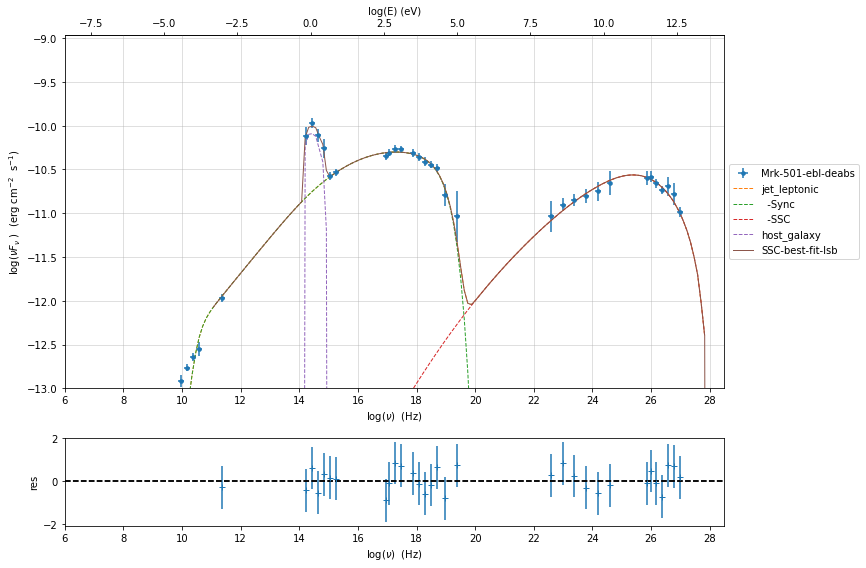

In [18]:
%matplotlib inline
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=fit_model_lsb.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

### Model fitting with Minuit

In [19]:
jet_minuit=Jet.load_model('prefit_jet_gal_templ.pkl')
jet_minuit.set_gamma_grid_size(200)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082278e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205572e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046425e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


To run the ``minuit`` minimizer we will use the best-fit results from ``lsb`` to set the boundaries for our parameters. 

In [20]:
fit_model_minuit=FitModel( jet=jet_minuit, name='SSC-best-fit-minuit',template=my_shape.host_gal) 
fit_model_minuit.show_model_components()
fit_model_minuit.freeze('jet_leptonic','z_cosm')
fit_model_minuit.freeze('jet_leptonic','R_H')
fit_model_minuit.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]
fit_model_minuit.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_minuit.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_minuit.host_galaxy.parameters.nu_scale.frozen=True
fit_model_minuit.jet_leptonic.parameters.gmin.fit_range=[10,1000]
fit_model_minuit.jet_leptonic.parameters.gmax.fit_range=[5E5,1E8]
fit_model_minuit.jet_leptonic.parameters.gamma0_log_parab.fit_range=[1E3,5E5]

model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(fit_model_minuit,sed_data,10.0**11,10**29.0,fitname='SSC-best-fit-minuit',repeat=3)


--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-minuit  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

--------------------------------------------------------------------------------
filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=8.08161e+00

fit run: 1
- old chisq=8.08161e+00


0it [00:00, ?it/s]

- best chisq=8.08161e+00

fit run: 2
- old chisq=8.08161e+00


0it [00:00, ?it/s]

- best chisq=8.08160e+00

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,6.621323e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.153693e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.642409e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.936304e+03,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.068010e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,1.966937e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.622731e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.031745e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.435717e+01,1.000000e-04,--,False,False



converged=True
calls=169
mesg=


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 8.082                      │              Nfcn = 169              │
│ EDM = 2.79e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │    66     │     7     │            │            │   10    │  1000   │       │
│ 1 │ par_1 │  2.15e6   │  0.04e6   │            │            │ 500000  │  1e+08  │       │
│ 2 │ par_2 │   26.4    │    2.1    │            │            │    0    │         │       │
│ 3 │ par_3 │  1.94e3   │  0.21e3   │            │            │  1000   │ 500000  │       │
│ 4 │ par_4 │   2.068   │   0.013   │            │            │   -10   │   10    │       │
│ 5 │ par_5 │   0.197   │   0.006   │            │            │   -15   │   15    │       │
│ 6 │ par_6 │  16.2e15  │  0.4e15   │            │            │3.16228e+15│3.16228e+17│       │
│ 7 │ par_7 │  10.3e-3  │  0.5e-3   │            │            │    0    │         │       │
│ 8 │ par_8 │   44.4    │    1.7    │            │            │    5    │   50    │       │
│ 9 │ par_9 │  -10.06   │   0.05    │            │            │-12.2541 │-8.25412 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│       │     par_0     par_1     par_2     par_3     par_4     par_5     par_6     par_7     par_8     par_9 │
├───────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ par_0 │      44.6  2.69e+05     -9.94       261    0.0268   0.00957  1.46e+14   0.00314     -9.08  -0.00478 │
│ par_1 │  2.69e+05  1.73e+09 -6.01e+04  1.78e+06       165      62.8   1.2e+18      18.5 -5.47e+04     -28.8 │
│ par_2 │     -9.94 -6.01e+04       4.3     -7.67   0.00276   -0.0024 -1.94e+14 -0.000692      1.78    0.0011 │
│ par_3 │       261  1.78e+06     -7.67  4.32e+04      1.53     0.727  1.53e+16    0.0179      -110     -0.01 │
│ par_4 │    0.0268       165   0.00276      1.53  0.000174 -7.06e-06  8.13e+11  1.83e-06   -0.0057 -1.81e-06 │
│ par_5 │   0.00957      62.8   -0.0024     0.727 -7.06e-06  4.19e-05  4.78e+11  7.25e-07  -0.00227 -1.99e-05 │
│ par_6 │  1.46e+14   1.2e+18 -1.94e+14  1.53e+16  8.13e+11  4.78e+11  1.52e+29  7.17e+09  -2.1e+14 -5.77e+11 │
│ par_7 │   0.00314      18.5 -0.000692    0.0179  1.83e-06  7.25e-07  7.17e+09  2.43e-07 -0.000675 -3.84e-07 │
│ par_8 │     -9.08 -5.47e+04      1.78      -110   -0.0057  -0.00227  -2.1e+14 -0.000675      2.72 -0.000979 │
│ par_9 │  -0.00478     -28.8    0.0011     -0.01 -1.81e-06 -1.99e-05 -5.77e+11 -3.84e-07 -0.000979    0.0025 │
└───────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

dof=21
chisq=8.081603, chisq/red=0.384838 null hypothesis sig=0.994789

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,6.621323e+01,6.621323e+01,6.680156e+00,--,1.487509e+02,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,2.153693e+06,2.153693e+06,4.154886e+04,--,2.310708e+06,5.000000e+05,1.000000e+08,False
jet_leptonic,N,2.642409e+01,2.642409e+01,2.072554e+00,--,3.082278e+01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,1.936304e+03,1.936304e+03,2.077966e+02,--,1.045843e+04,1.000000e+03,5.000000e+05,False
jet_leptonic,s,2.068010e+00,2.068010e+00,1.319035e-02,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,1.966937e-01,1.966937e-01,6.470060e-03,--,3.205572e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.622731e+16,1.622731e+16,3.892667e+14,--,1.046425e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.031745e-02,1.031745e-02,4.928371e-04,--,5.050000e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,4.435717e+01,4.435717e+01,1.646839e+00,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




for further information regardin minuit please refer to https://iminuit.readthedocs.io/en/v1.5.4/

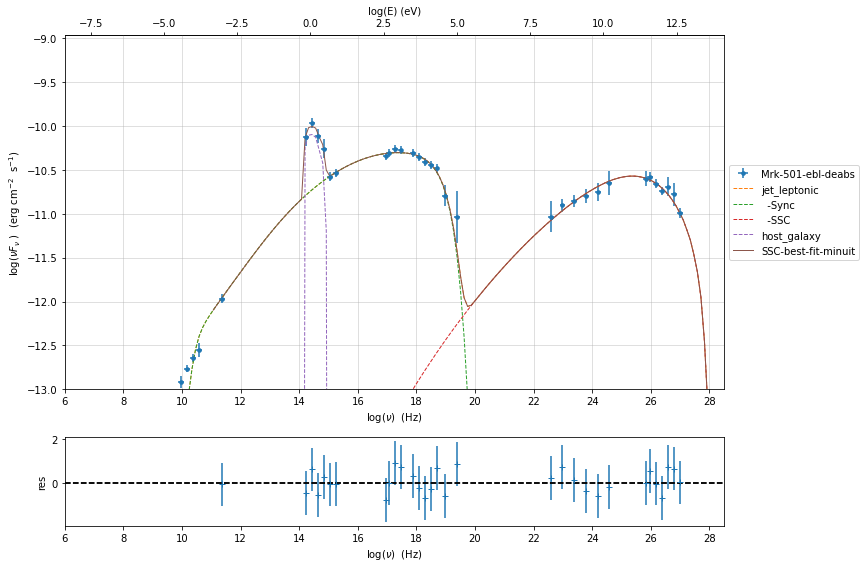

In [21]:
%matplotlib inline
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
p2=fit_model_minuit.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

In [22]:
best_fit_minuit.save_report('SSC-best-fit-minuit.pkl')
model_minimizer_minuit.save_model('model_minimizer_minuit.pkl')
fit_model_minuit.save_model('fit_model_minuit.pkl')

best_fit_lsb.bestfit_table

model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str12,str16,float64,float64,float64,float64,float64,float64,float64,bool
jet_leptonic,gmin,9.629577e+01,9.629577e+01,1.604038e+02,--,1.487509e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,2.094901e+06,2.094901e+06,9.384097e+05,--,2.310708e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,2.649381e+01,2.649381e+01,9.557869e+01,--,3.082278e+01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,5.732044e+03,5.732044e+03,9.690316e+03,--,1.045843e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.179803e+00,2.179803e+00,2.636698e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,2.270824e-01,2.270824e-01,4.581071e-02,--,3.205572e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,1.364911e+16,1.364911e+16,1.776107e+16,--,1.046425e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.227782e-02,1.227782e-02,4.927832e-03,--,5.050000e-02,0.000000e+00,--,False


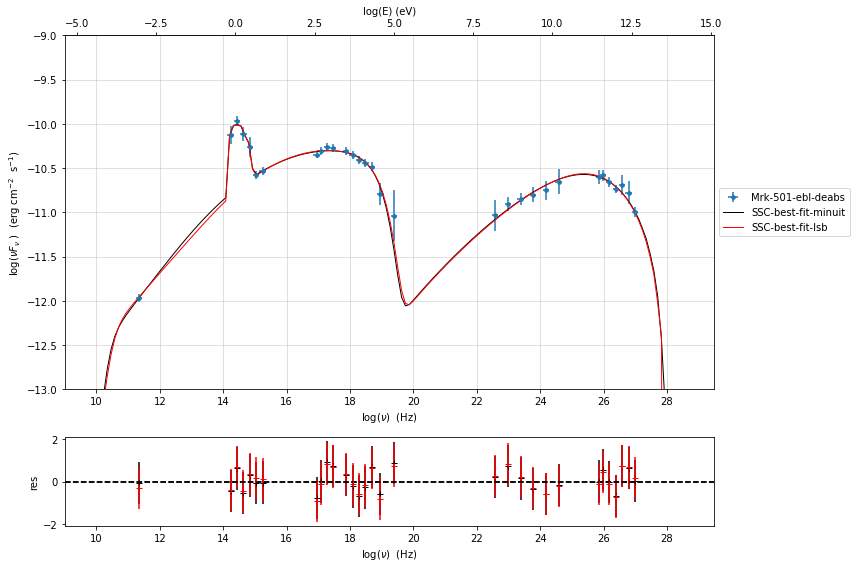

In [23]:
%matplotlib inline
from jetset.plot_sedfit import PlotSED
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=PlotSED()
p2.add_data_plot(sed_data,fit_range=[ 11., 29.])
p2.add_model_plot(fit_model_minuit,color='black')
p2.add_residual_plot(fit_model_minuit,sed_data,fit_range=[ 11., 29.],color='black')
p2.add_model_plot(fit_model_lsb,color='red')
p2.add_residual_plot(fit_model_lsb,sed_data,fit_range=[ 11., 29.],color='red')
p2.rescale(y_min=-13,y_max=-9,x_min=9,x_max=29.5)

### Model fitting with a bkn pl


In [24]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='bkn',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E11,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet_bkn_gal_templ.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,1.092459e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,3.008910e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.360000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.927085e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.993548e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.003808e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,2.012047e+05,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False


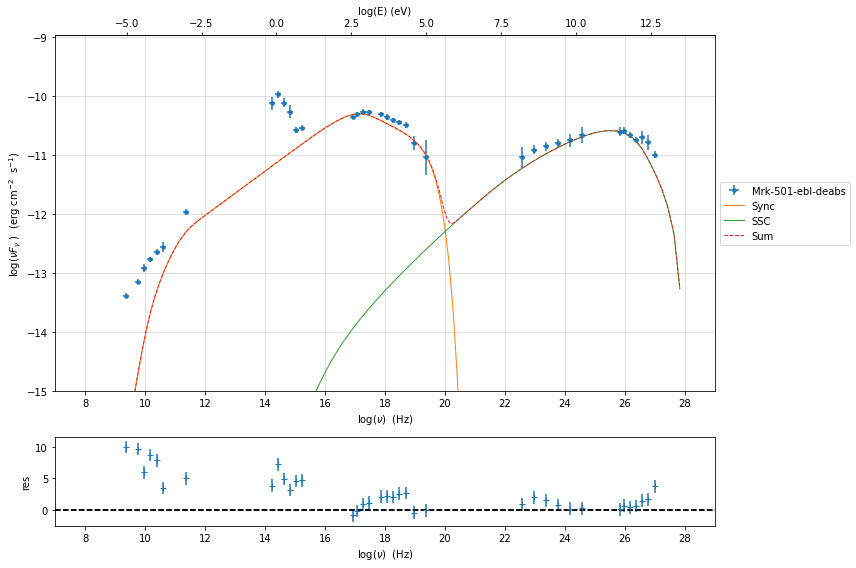

In [25]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.rescale(y_min=-15,x_min=7,x_max=29)

In [26]:
jet_minuit_bkn=Jet.load_model('prefit_jet_bkn_gal_templ.pkl')
jet_minuit_bkn.set_gamma_grid_size(200)

fit_model_lsb_bkn=FitModel( jet=jet_minuit_bkn, name='SSC-best-fit-bkn-lsb',template=my_shape.host_gal) 


fit_model_lsb_bkn.freeze(jet_lsb,'z_cosm')
fit_model_lsb_bkn.freeze(jet_lsb,'R_H')
fit_model_lsb_bkn.jet_leptonic.parameters.beam_obj.fit_range=[5,50]
fit_model_lsb_bkn.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb_bkn.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_lsb_bkn.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_lsb_bkn.host_galaxy.parameters.nu_scale.frozen=True

model_minimizer_lsb_bkn=ModelMinimizer('lsb')
best_fit_lsb_bkn=model_minimizer_lsb_bkn.fit(fit_model_lsb_bkn,sed_data,1E11,1E29,fitname='SSC-best-fit-lsb',repeat=3)


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.927085e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.993548e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.003808e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,2.012047e+05,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.092459e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,3.008910e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=1.03947e+01

fit run: 1
- old chisq=1.03947e+01


0it [00:00, ?it/s]

- best chisq=1.03947e+01

fit run: 2
- old chisq=1.03947e+01


0it [00:00, ?it/s]

- best chisq=1.03947e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-lsb


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.976543e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.733513e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.272620e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,5.695694e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.260640e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,2.954284e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.386842e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.406628e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.021062e+01,1.000000e-04,--,False,False



converged=True
calls=21
mesg=


'The relative error between two consecutive iterates is at most 0.000000'

dof=21
chisq=10.394711, chisq/red=0.494986 null hypothesis sig=0.973318

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,1.976543e+02,1.976543e+02,2.596301e+02,--,1.927085e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,1.733513e+06,1.733513e+06,6.095014e+05,--,2.993548e+06,1.000000e+04,1.000000e+08,False
jet_leptonic,N,1.272620e+01,1.272620e+01,9.965061e+00,--,2.003808e+01,0.000000e+00,--,False
jet_leptonic,gamma_break,5.695694e+04,5.695694e+04,2.541471e+04,--,2.012047e+05,1.000000e+00,1.000000e+09,False
jet_leptonic,p,2.260640e+00,2.260640e+00,1.110064e-01,--,2.248787e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,p_1,2.954284e+00,2.954284e+00,5.968115e-02,--,3.500000e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,R,1.386842e+16,1.386842e+16,1.356126e+16,--,1.092459e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.406628e-02,1.406628e-02,6.163953e-03,--,3.008910e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,4.021062e+01,4.021062e+01,1.603289e+01,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




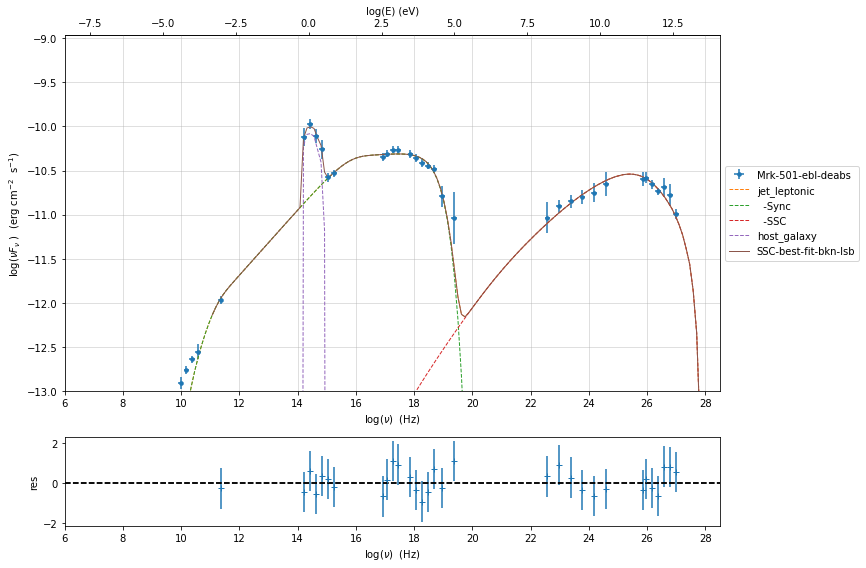

In [27]:
%matplotlib inline
fit_model_lsb_bkn.set_nu_grid(1E6,1E30,200)
fit_model_lsb_bkn.eval()
p2=fit_model_lsb_bkn.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

In [28]:
jet_minuit_bkn=Jet.load_model('prefit_jet_bkn_gal_templ.pkl')
jet_minuit_bkn.set_gamma_grid_size(200)


fit_model_minuit_bkn=FitModel( jet=jet_minuit_bkn, name='SSC-best-fit-minuit-bkn',template=my_shape.host_gal) 
fit_model_minuit_bkn.show_model_components()
fit_model_minuit_bkn.freeze('jet_leptonic','z_cosm')
fit_model_minuit_bkn.freeze('jet_leptonic','R_H')
fit_model_minuit_bkn.jet_leptonic.parameters.beam_obj.fit_range=[5,50]
fit_model_minuit_bkn.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_minuit_bkn.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_minuit_bkn.host_galaxy.parameters.nu_scale.frozen=True
fit_model_minuit_bkn.jet_leptonic.parameters.gmin.fit_range=[10,1000]
fit_model_minuit_bkn.jet_leptonic.parameters.gmax.fit_range=[5E5,1E8]
fit_model_minuit_bkn.jet_leptonic.parameters.gamma_break.fit_range=[1E3,1E6]
fit_model_minuit_bkn.jet_leptonic.parameters.p.fit_range=[1,3]
fit_model_minuit_bkn.jet_leptonic.parameters.p_1.fit_range=[2,5]


model_minimizer_minuit_bkn=ModelMinimizer('minuit')
best_fit_minuit_bkn=model_minimizer_minuit.fit(fit_model_minuit_bkn,sed_data,1E11,1E29,fitname='SSC-best-fit-minuit-bkn',repeat=3)

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.927085e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.993548e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,2.003808e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,2.012047e+05,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.092459e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,3.008910e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False



--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-minuit-bkn  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet
 -model name: host_galaxy model type: template

--------------------------------------------------------------------------------
filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 31

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

- best chisq=1.04530e+01

fit run: 1
- old chisq=1.04530e+01


0it [00:00, ?it/s]

- best chisq=1.04529e+01

fit run: 2
- old chisq=1.04529e+01


0it [00:00, ?it/s]

- best chisq=1.04529e+01

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit-bkn


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.478583e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.817009e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.612197e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,5.774642e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,2.245350e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,2.963911e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,R,region_size,cm,1.461258e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.351751e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,3.995481e+01,1.000000e-04,--,False,False



converged=True
calls=171
mesg=


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 10.45                      │              Nfcn = 171              │
│ EDM = 1.21e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │   147.9   │    1.3    │            │            │   10    │  1000   │       │
│ 1 │ par_1 │  1.817e6  │  0.014e6  │            │            │ 500000  │  1e+08  │       │
│ 2 │ par_2 │   16.1    │    2.2    │            │            │    0    │         │       │
│ 3 │ par_3 │   58e3    │    9e3    │            │            │  1000   │  1e+06  │       │
│ 4 │ par_4 │   2.25    │   0.04    │            │            │    1    │    3    │       │
│ 5 │ par_5 │   2.96    │   0.04    │            │            │    2    │    5    │       │
│ 6 │ par_6 │  14.6e15  │  0.4e15   │            │            │3.16228e+15│3.16228e+17│       │
│ 7 │ par_7 │  13.5e-3  │  0.5e-3   │            │            │    0    │         │       │
│ 8 │ par_8 │   39.95   │   0.20    │            │            │    5    │   50    │       │
│ 9 │ par_9 │  -10.05   │   0.05    │            │            │-12.2541 │-8.25412 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│       │     par_0     par_1     par_2     par_3     par_4     par_5     par_6     par_7     par_8     par_9 │
├───────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ par_0 │      1.59      -860     0.709  1.95e+03     0.013  -0.00579 -6.38e+13  -1.1e-05   -0.0991   0.00181 │
│ par_1 │      -860  1.96e+08  1.17e+04  3.31e+07       200     -13.5 -4.35e+17      0.72 -1.09e+03      17.5 │
│ par_2 │     0.709  1.17e+04      4.94  1.12e+04    0.0785   -0.0306 -2.07e+14  -0.00029    -0.135   0.00905 │
│ par_3 │  1.95e+03  3.31e+07  1.12e+04  8.55e+07       255      86.2  1.93e+17     -1.13      -421      42.1 │
│ par_4 │     0.013       200    0.0785       255   0.00148 -0.000404  2.21e+11 -5.44e-06  -0.00239   0.00017 │
│ par_5 │  -0.00579     -13.5   -0.0306      86.2 -0.000404   0.00138  1.77e+12  6.91e-06  0.000566 -0.000104 │
│ par_6 │ -6.38e+13 -4.35e+17 -2.07e+14  1.93e+17  2.21e+11  1.77e+12  1.58e+29 -1.02e+11  4.93e+11 -6.35e+11 │
│ par_7 │  -1.1e-05      0.72  -0.00029     -1.13 -5.44e-06  6.91e-06 -1.02e+11   2.8e-07 -9.55e-06 -1.63e-06 │
│ par_8 │   -0.0991 -1.09e+03    -0.135      -421  -0.00239  0.000566  4.93e+11 -9.55e-06    0.0419 -0.000305 │
│ par_9 │   0.00181      17.5   0.00905      42.1   0.00017 -0.000104 -6.35e+11 -1.63e-06 -0.000305   0.00243 │
└───────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

dof=21
chisq=10.452939, chisq/red=0.497759 null hypothesis sig=0.972411

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,1.478583e+02,1.478583e+02,1.259638e+00,--,1.927085e+02,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,1.817009e+06,1.817009e+06,1.401761e+04,--,2.993548e+06,5.000000e+05,1.000000e+08,False
jet_leptonic,N,1.612197e+01,1.612197e+01,2.221670e+00,--,2.003808e+01,0.000000e+00,--,False
jet_leptonic,gamma_break,5.774642e+04,5.774642e+04,9.246105e+03,--,2.012047e+05,1.000000e+03,1.000000e+06,False
jet_leptonic,p,2.245350e+00,2.245350e+00,3.840352e-02,--,2.248787e+00,1.000000e+00,3.000000e+00,False
jet_leptonic,p_1,2.963911e+00,2.963911e+00,3.710695e-02,--,3.500000e+00,2.000000e+00,5.000000e+00,False
jet_leptonic,R,1.461258e+16,1.461258e+16,3.968829e+14,--,1.092459e+16,3.162278e+15,3.162278e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.351751e-02,1.351751e-02,5.288408e-04,--,3.008910e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,3.995481e+01,3.995481e+01,2.045940e-01,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




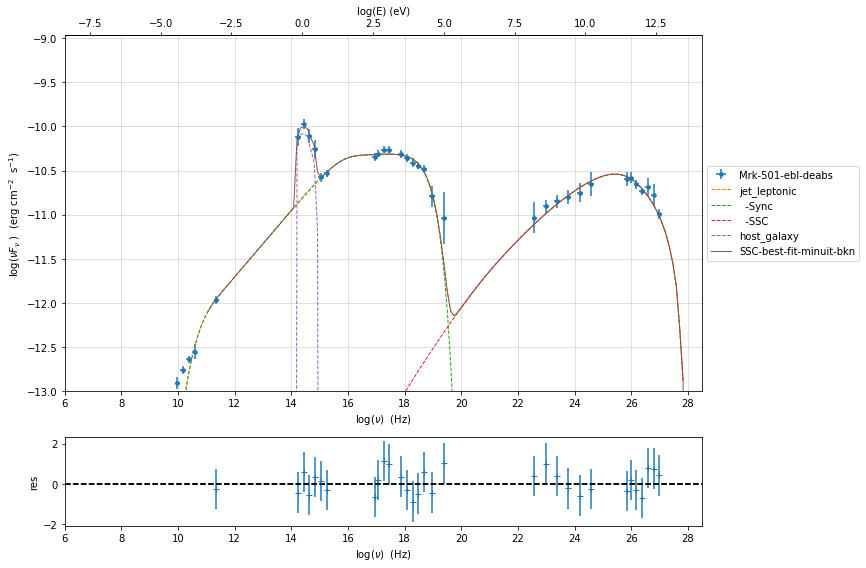

In [29]:
%matplotlib inline
fit_model_minuit_bkn.set_nu_grid(1E6,1E30,200)
fit_model_minuit_bkn.eval()
p2=fit_model_minuit_bkn.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

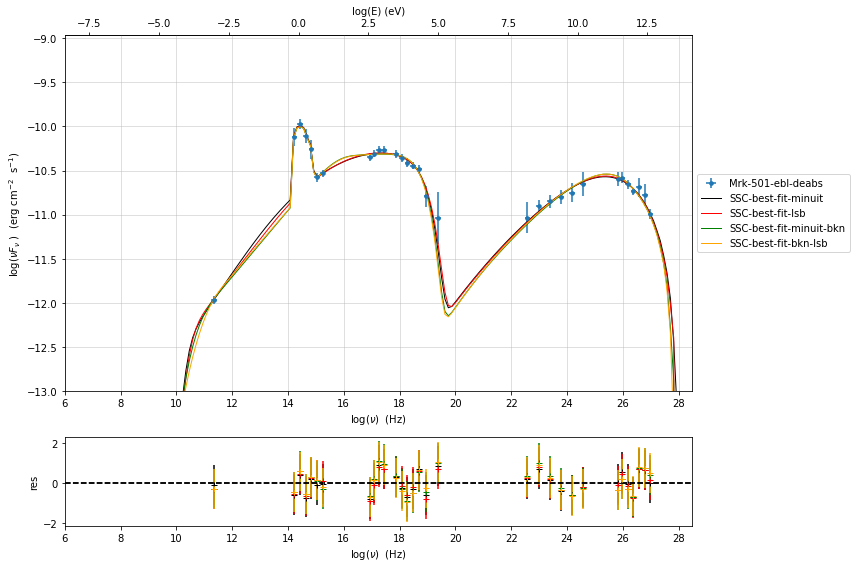

In [30]:
%matplotlib inline
from jetset.plot_sedfit import PlotSED
fit_model_minuit_bkn.set_nu_grid(1E6,1E30,200)
fit_model_minuit_bkn.eval()
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
fit_model_lsb_bkn.set_nu_grid(1E6,1E30,200)
fit_model_lsb_bkn.eval()
p2=PlotSED()
p2.add_data_plot(sed_data,fit_range=[ 11., 29.])
p2.add_model_plot(fit_model_minuit,color='black')
p2.add_residual_plot(fit_model_minuit,sed_data,fit_range=[ 11. ,29.],color='black')
p2.add_model_plot(fit_model_lsb,color='red')
p2.add_residual_plot(fit_model_lsb,sed_data,fit_range=[ 11., 29.],color='red')
p2.add_model_plot(fit_model_minuit_bkn,color='green')
p2.add_residual_plot(fit_model_minuit_bkn,sed_data,fit_range=[ 11., 29.],color='green')
p2.add_model_plot(fit_model_lsb_bkn,color='orange')
p2.add_residual_plot(fit_model_lsb_bkn,sed_data,fit_range=[ 11., 29.],color='orange')
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

## MCMC sampling

In [31]:
from jetset.mcmc import McmcSampler
from jetset.minimizer import ModelMinimizer


We  used a flat prior  centered on the best fit value.   Setting `bound=5.0` and `bound_rel=True` means that:
    
1) the prior interval will be defined as  [best_fit_val - delta_m , best_fit_val + delta_p] 

2) with delta_p=delta_m=best_fit_val*bound

If we set `bound_rel=False` then   delta_p = delta_m = best_fit_err*bound

It is possible to define asymmetric boundaries e.g. `bound=[2.0,5.0]` meaning that 

1) for `bound_rel=True` 

     delta_p = best_fit_val*bound[1]

     delta_m =b est_fit_val*bound[0]

2)  for `bound_rel=False` 

    delta_p = best_fit_err*bound[1]

    delta_m = best_fit_err*bound[0]

In the next release a more flexible prior interface will be added, including different type of priors

Given the large parameter space, we select a sub sample of parameters using the `use_labels_dict`. If we do not pass the 'use_labels_dict' the full set of free parameters will be used



In [32]:
model_minimizer_lsb = ModelMinimizer.load_model('model_minimizer_lsb.pkl')


mcmc=McmcSampler(model_minimizer_lsb)

labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=50,bound=5.0,bound_rel=True,threads=None,walker_start_bound=0.005,use_labels_dict=use_labels_dict)

mcmc run starting



  0%|          | 0/50 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 436.39 seconds


In [33]:
print(mcmc.acceptance_fraction)

0.54953125


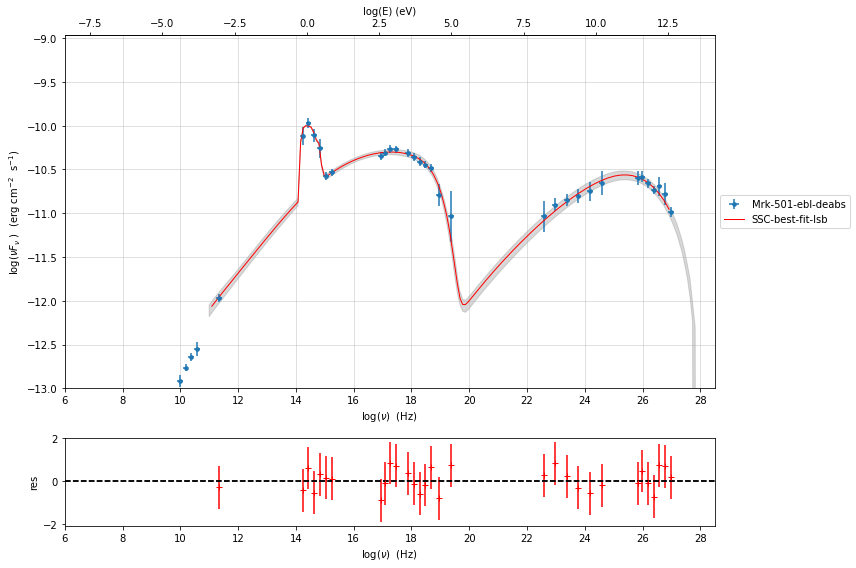

In [34]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[11., 27.],size=50)
p.rescale(y_min=-13,x_min=6,x_max=28.5)

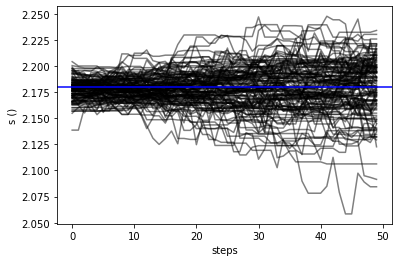

In [49]:
f=mcmc.plot_chain('s',log_plot=False)

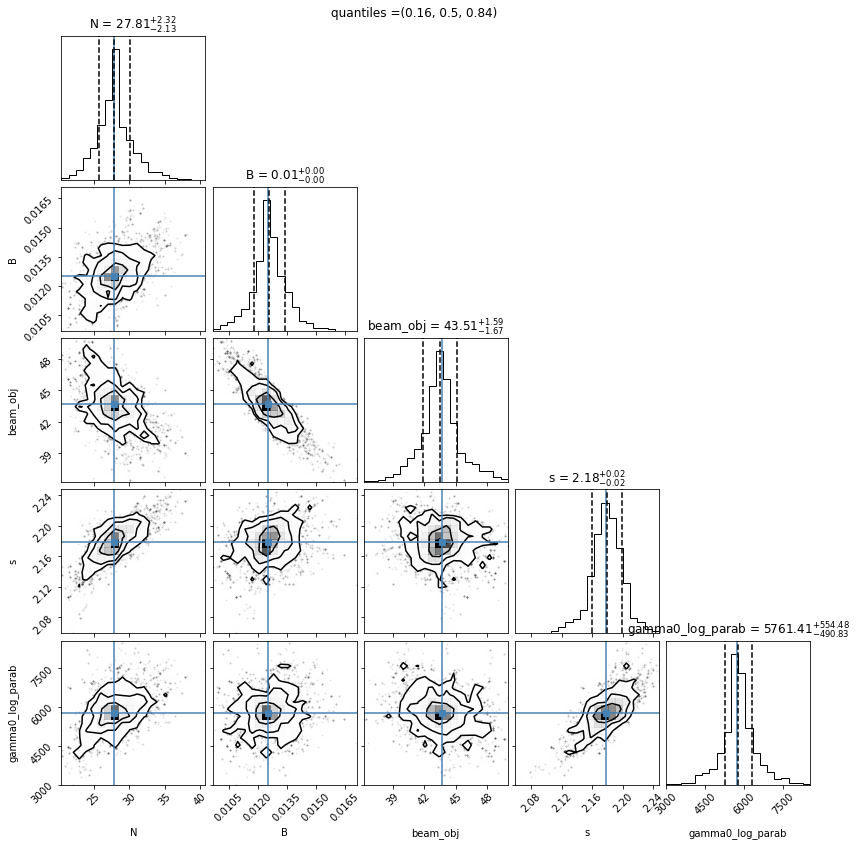

In [50]:
f=mcmc.corner_plot()

In [51]:
mcmc.get_par('N')

(array([27.13365648, 27.56888754, 27.44743786, ..., 31.04123012,
        20.41634151, 31.10457229]),
 0)

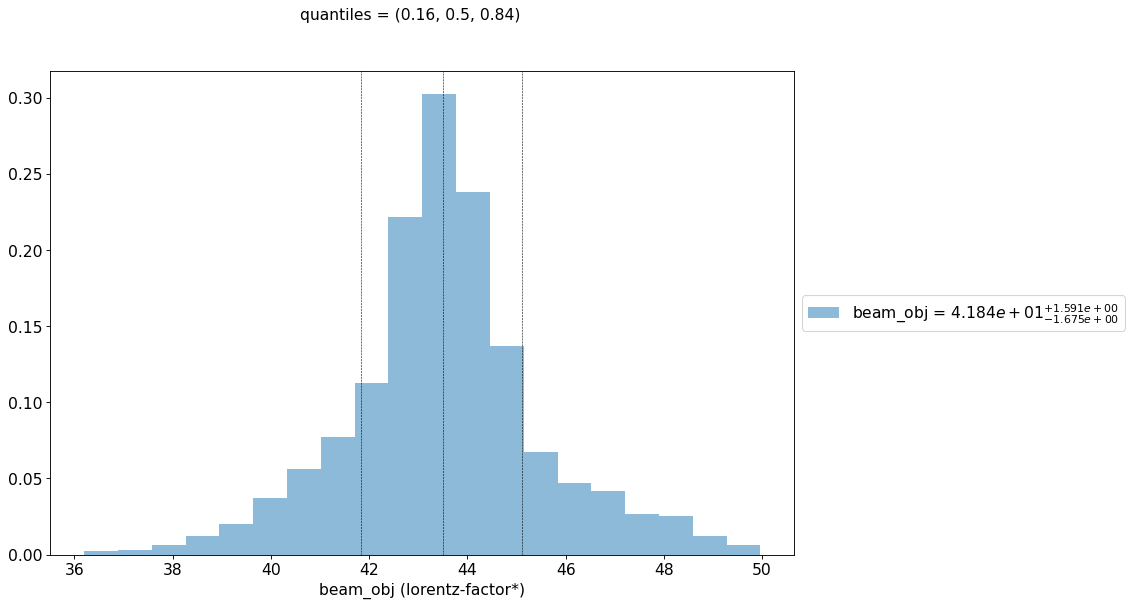

In [52]:
f=mcmc.plot_par('beam_obj')

The posterior of the beaming factor is clearly truncated, so we should rerun the fit changing the constrain on `beam_obj` parameter.

In [53]:
from jetset.model_manager import  FitModel
from jetset.jet_model import Jet

jet_lsb=Jet.load_model('prefit_jet_gal_templ.pkl')
jet_lsb.set_gamma_grid_size(200)


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.487509e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,3.082278e+01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205572e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.046425e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


In [54]:
fit_model_lsb=FitModel( jet=jet_lsb, name='SSC-best-fit-lsb',template=my_shape.host_gal) 


In [55]:
fit_model_lsb.freeze('jet_leptonic','z_cosm')
fit_model_lsb.freeze('jet_leptonic','R_H')
fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range=[5., 100.]
fit_model_lsb.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb.jet_leptonic.parameters.gmax.fit_range=[1E4,1E8]
fit_model_lsb.host_galaxy.parameters.nuFnu_p_host.frozen=False
fit_model_lsb.host_galaxy.parameters.nu_scale.frozen=True

In [56]:
model_minimizer_lsb=ModelMinimizer('lsb')
best_fit_lsb=model_minimizer_lsb.fit(fit_model_lsb,sed_data,10.0**11,10**29.0,fitname='SSC-best-fit-lsb',repeat=3,silent=True)

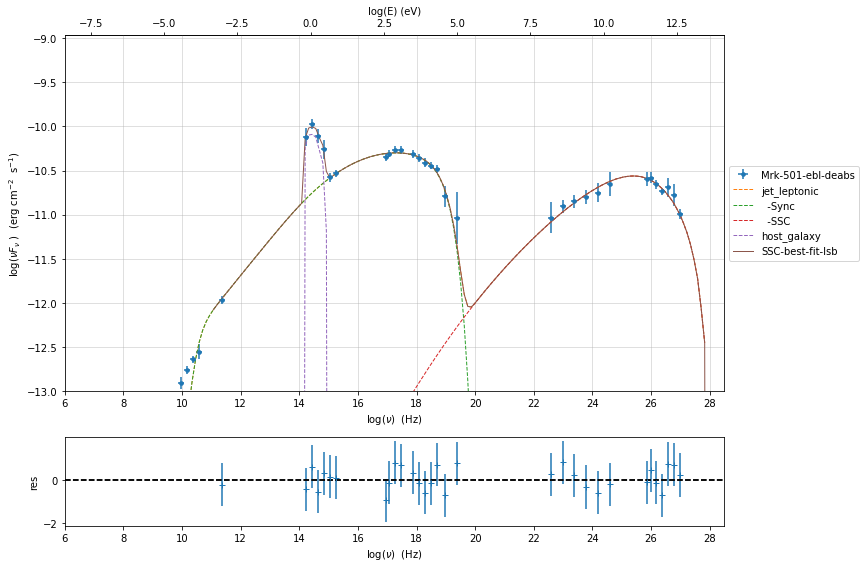

In [57]:
%matplotlib inline
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=fit_model_lsb.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

In [58]:
best_fit_lsb.save_report('SSC-best-fit-lsb.pkl')
model_minimizer_lsb.save_model('model_minimizer_lsb.pkl')
fit_model_lsb.save_model('fit_model_lsb.pkl')

In [59]:
model_minimizer_lsb = ModelMinimizer.load_model('model_minimizer_lsb.pkl')


mcmc=McmcSampler(model_minimizer_lsb)

labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=50,bound=5.0,bound_rel=True,threads=None,walker_start_bound=0.005,use_labels_dict=use_labels_dict)

mcmc run starting



  0%|          | 0/50 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 452.72 seconds


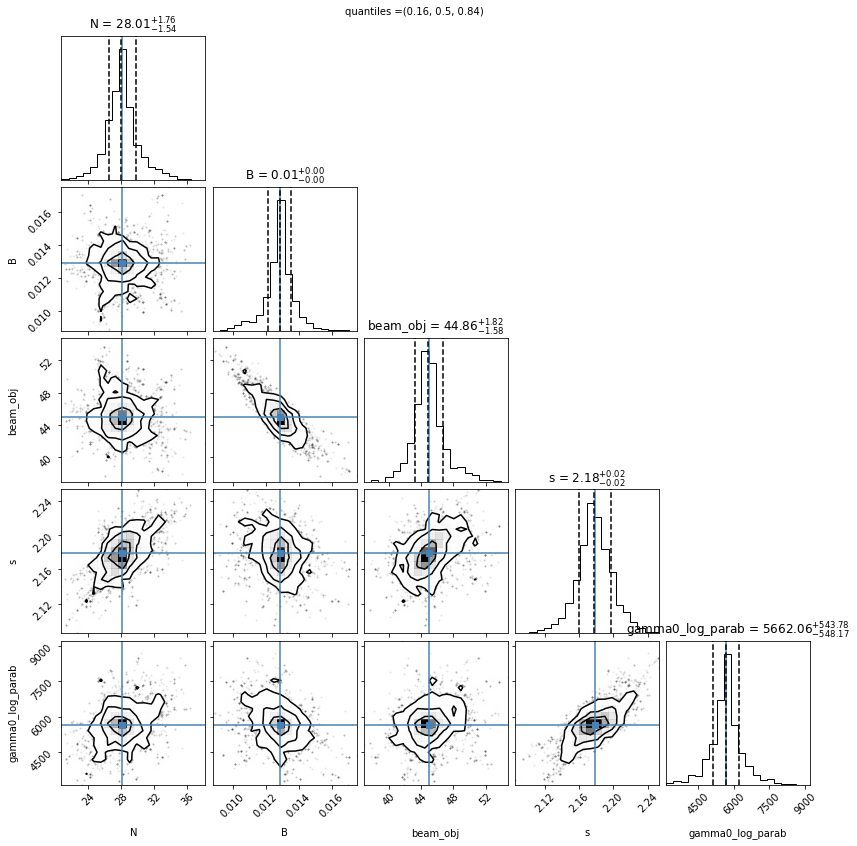

In [60]:
f=mcmc.corner_plot()

## Save and reuse MCMC

In [61]:
mcmc.save('mcmc_sampler.pkl')

In [62]:
from jetset.mcmc import McmcSampler
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

sed_data=ObsData.load('Mrk_501.pkl')

ms=McmcSampler.load('mcmc_sampler.pkl')

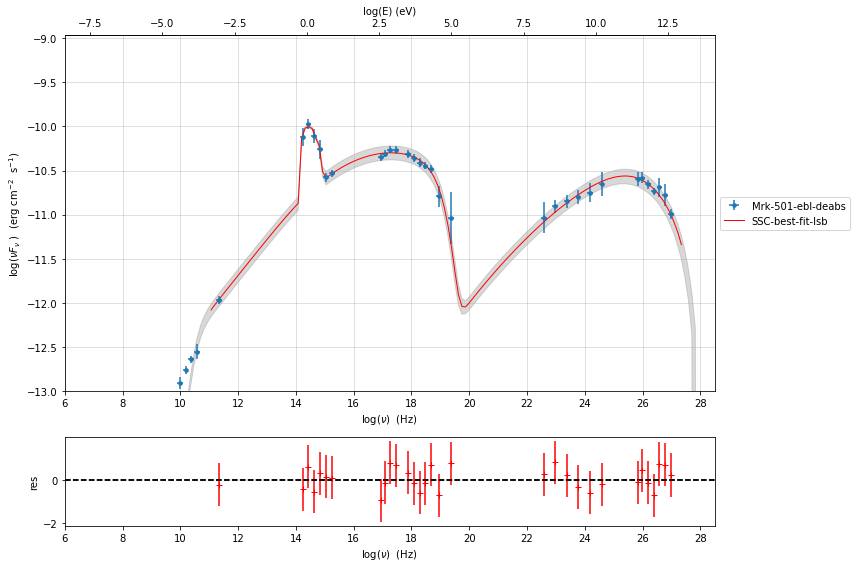

In [63]:
p=ms.plot_model(sed_data=sed_data,fit_range=[11., 27.4],size=50)
p.rescale(y_min=-13,x_min=6,x_max=28.5)

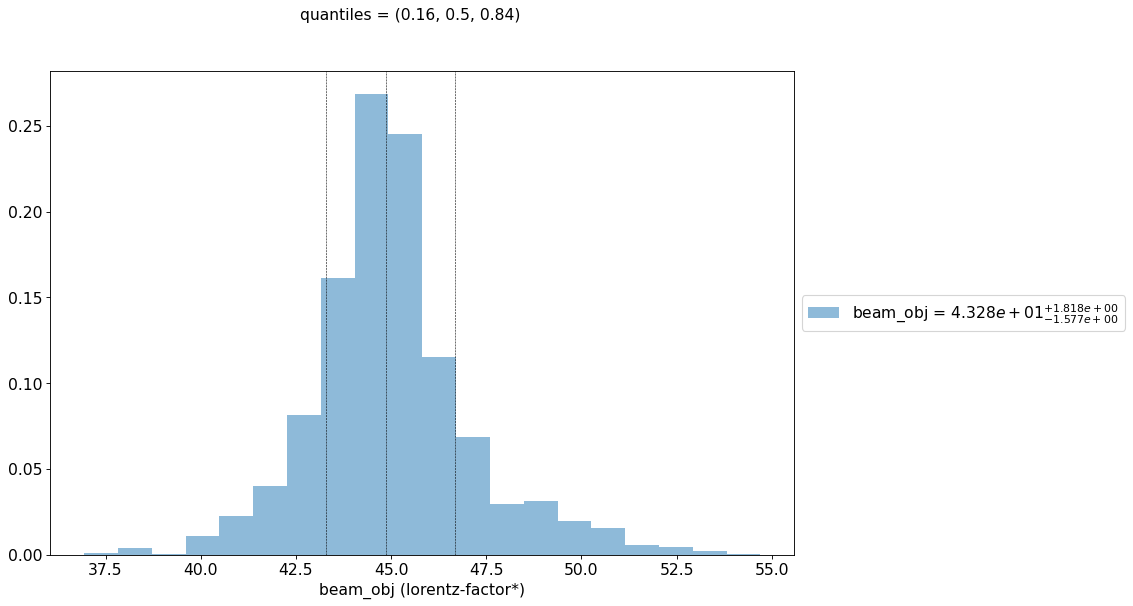

In [64]:
f=ms.plot_par('beam_obj',log_plot=False)


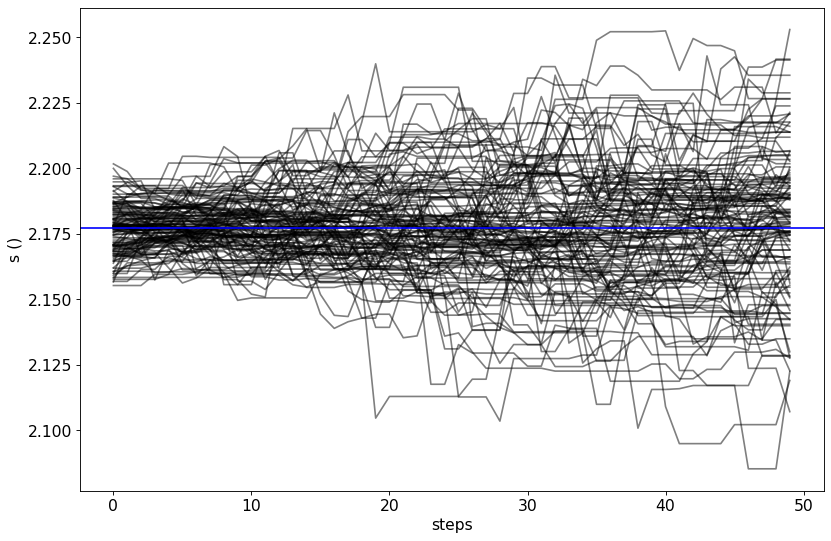

In [65]:
f=ms.plot_chain('s',log_plot=False)